# Lab 9
## Machine Learning

# Bayesian Generalised Linear Models and Hierarchical Models

### Importing Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ucimlrepo
import pandas as pd
import pymc as pm
import arviz as az
import xarray as xr

### Data: Bike Rentals

We are going to use first the dataset on hourly bike rentals in Seoul from the Lecture. We'll be modelling rental counts based on temperature. More information is available here: https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand.

Let's first load in and visualise the data.

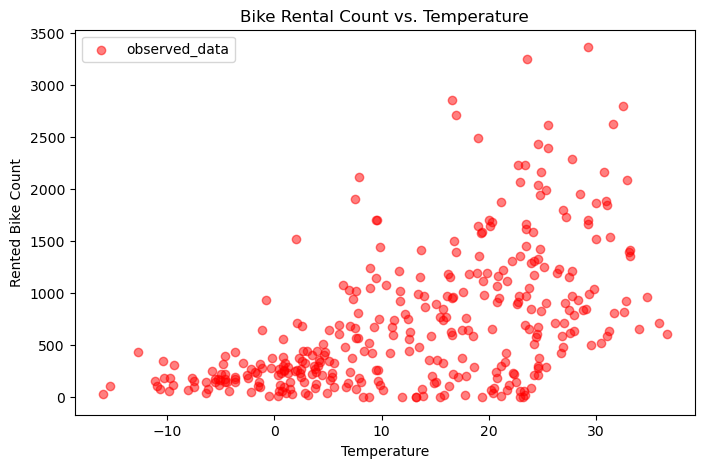

In [2]:
# Load dataset (requires internet)
bikes = ucimlrepo.fetch_ucirepo(id=560)
X_df = bikes.data.features

# Set seed and sample
RANDOM_SEED = 42
rng = np.random.RandomState(RANDOM_SEED)
N = 348
sampled_index = rng.choice(range(X_df.shape[0]), size=N, replace=False)
X_df = X_df.iloc[sampled_index, :]

x = X_df["Temperature"].values
y = X_df["Rented Bike Count"].values

# Sort for visualization
idx = np.argsort(x)
x = x[idx]
y = y[idx]

# Visualise
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x, y, alpha=0.5, c="red", label="observed_data")
ax.set_xlabel("Temperature")
ax.set_ylabel("Rented Bike Count")
ax.set_title("Bike Rental Count vs. Temperature")
ax.legend()

### Gaussian Linear Model

We start with a basic linear regression using a Gaussian likelihood. This is not ideal for count data, but serves as a baseline.

In [3]:
gaussian_model = pm.Model()

with gaussian_model:
    theta0 = pm.Normal("theta0", mu=0, sigma=100)
    theta1 = pm.Normal("theta1", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", 10)
    y_pred = pm.Normal("y_pred", mu=theta0 + theta1 * x, sigma=sigma, observed=y)

with gaussian_model:
    idata1 = pm.sample(draws=10_000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta0, theta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 89 seconds.


Here we plot the posterior distribution for our coefficients.

array([<Axes: title={'center': 'theta0'}>,
       <Axes: title={'center': 'theta1'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

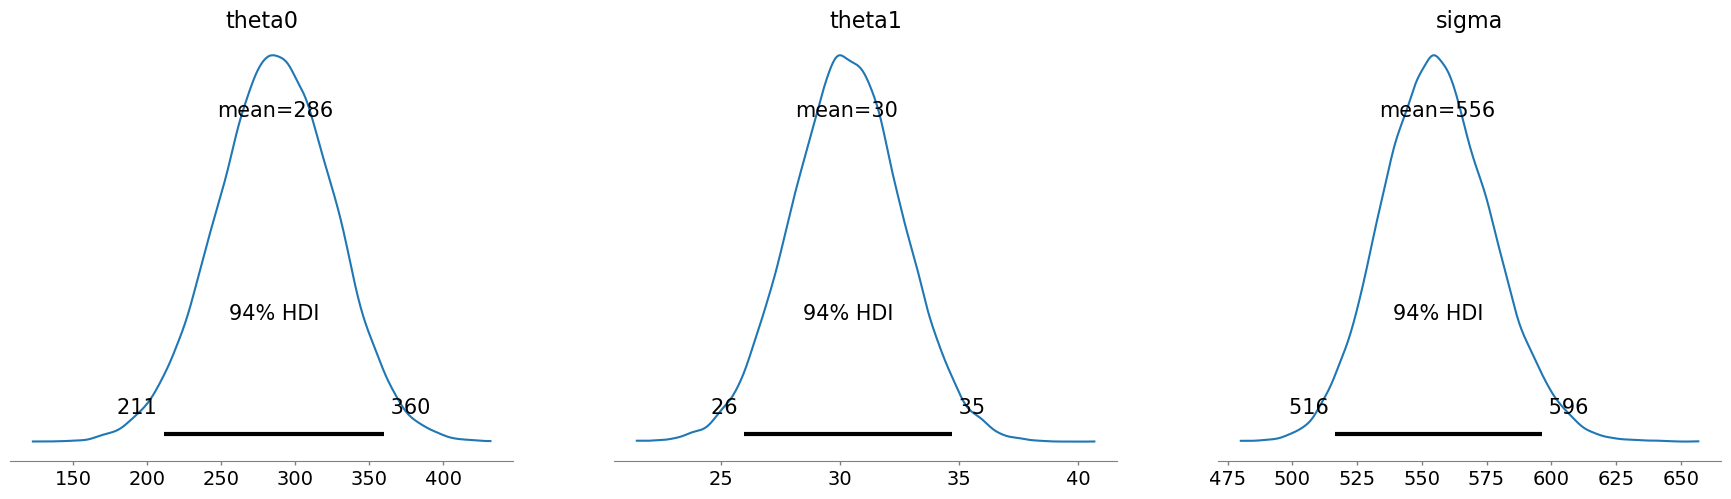

In [4]:
az.plot_posterior(idata1, var_names=["theta0", "theta1", "sigma"])

Now we use the posterior samples of the parameters to calculate the model-predicted mean values and store them a new variable in the `idata.posterior` group.

In [5]:
idata1.posterior["y_model"] = idata1.posterior["theta0"] + idata1.posterior["theta1"] * xr.DataArray(x)

And summarise the estimates of our model.

In [6]:
az.summary(idata1, round_to=2, hdi_prob=0.90)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta0,286.14,39.57,220.42,350.47,0.26,0.18,22327.14,25545.82,1.0
theta1,30.26,2.33,26.45,34.10,0.02,0.01,22397.46,26310.01,1.0
sigma,556.13,21.29,521.44,591.49,0.13,0.11,28282.38,26002.91,1.0
y_model[0],-198.05,70.62,-314.95,-83.32,0.50,0.36,20209.94,22796.57,1.0
y_model[1],-176.87,69.13,-291.80,-64.82,0.49,0.35,20212.32,22632.38,1.0
...,...,...,...,...,...,...,...,...,...
y_model[343],1290.83,57.51,1195.10,1383.77,0.31,0.26,33776.12,30890.37,1.0
y_model[344],1315.04,59.13,1216.01,1410.04,0.32,0.26,33275.42,30544.31,1.0
y_model[345],1339.25,60.77,1239.99,1439.42,0.34,0.27,32814.95,30349.69,1.0
y_model[346],1372.54,63.04,1265.35,1472.10,0.35,0.28,32233.64,29731.67,1.0


Now we plot the linear model itself, including our variability in the mean. Do you think this is a good moded? Does it fit the data well?

c:\Users\killi\anaconda3\envs\ml2025\Lib\site-packages\arviz\plots\lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


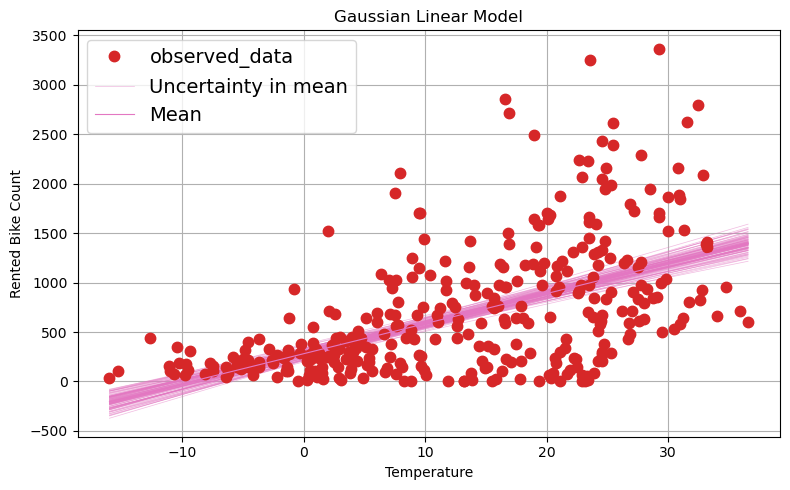

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
az.plot_lm(idata=idata1, y="y_pred", num_samples=100, x=x, axes=ax, y_model="y_model")
ax.set_title("Gaussian Linear Model")
ax.set_xlabel("Temperature")
ax.set_ylabel("Rented Bike Count")
fig.tight_layout()

To check our model lets sample from the posterior predictive distribution to get an idea of what future draws from the data would look like according to our model. Do you think these make sense? what is the problem that we identified in the lecture?

Sampling: [y_pred]


Output()

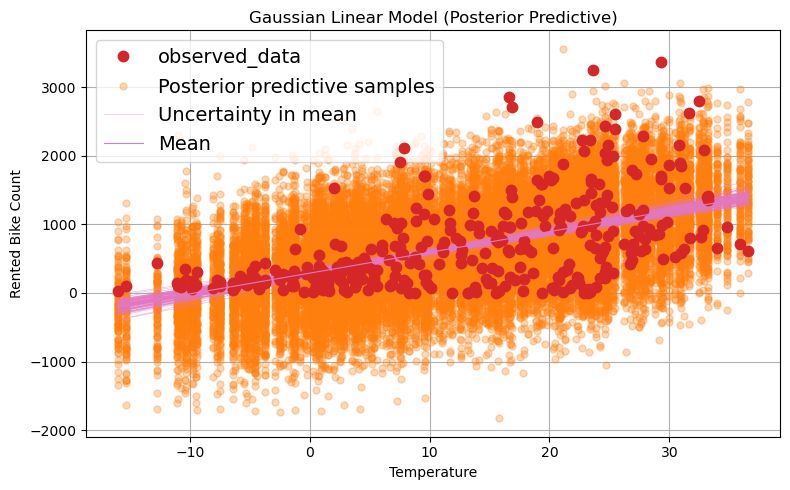

In [8]:
with gaussian_model:
    pm.sample_posterior_predictive(trace=idata1, extend_inferencedata=True)

fig, ax = plt.subplots(figsize=(8, 5))
az.plot_lm(idata=idata1, y="y_pred", num_samples=100, axes=ax, x=x, y_model="y_model")
ax.set_title("Gaussian Linear Model (Posterior Predictive)")
ax.set_xlabel("Temperature")
ax.set_ylabel("Rented Bike Count")
fig.tight_layout()

## Generalised Linear Modelling: The Negative Binomial Model

The negative binomial distribution is better suited for count data with overdispersion (when the variance of data is greater than the mean, violating a key assumption of the Poisson distribution which is often used for count data).

I highly recommend exploring different distributions, their associated stories, parameters and distributions at this link from the lecture: https://distribution-explorer.github.io/discrete/negative_binomial.html.

We model the outcome variable $y$ using a **Negative Binomial** likelihood with a **log link function**. The model is specified as follows:

### 1. Linear Predictor

$$
\eta_i = \theta_0 + \theta_1 x_i
$$

### 2. Link Function

We use the exponential function to ensure the mean parameter $\mu_i$ is positive:

$$
\mu_i = \exp(\eta_i) = \exp(\theta_0 + \theta_1 x_i)
$$

### 3. Likelihood

Given the mean $\mu_i$ and dispersion parameter $\alpha$, the response variable $y_i$ is modeled as:

$$
y_i \sim \text{NegativeBinomial}(\mu_i, \alpha)
$$

Where $\alpha$ is the inverse dispersion parameter controlling overdispersion.

### 4. Priors

We place priors on the model parameters as follows:

$$
\begin{aligned}
\theta_0 &\sim \mathcal{N}(0, 1) \\
\theta_1 &\sim \mathcal{N}(0, 10) \\
\alpha &\sim \text{HalfCauchy}(10)
\end{aligned}
$$

See if you can translate all that into our PyMC modelling framework and then run the model with 10,000 draws, storing the results in `idata2`.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta0, theta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 88 seconds.


Now plot the posterior distributions for theta0, thata1 and sigma.

array([<Axes: title={'center': 'theta0'}>,
       <Axes: title={'center': 'theta1'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

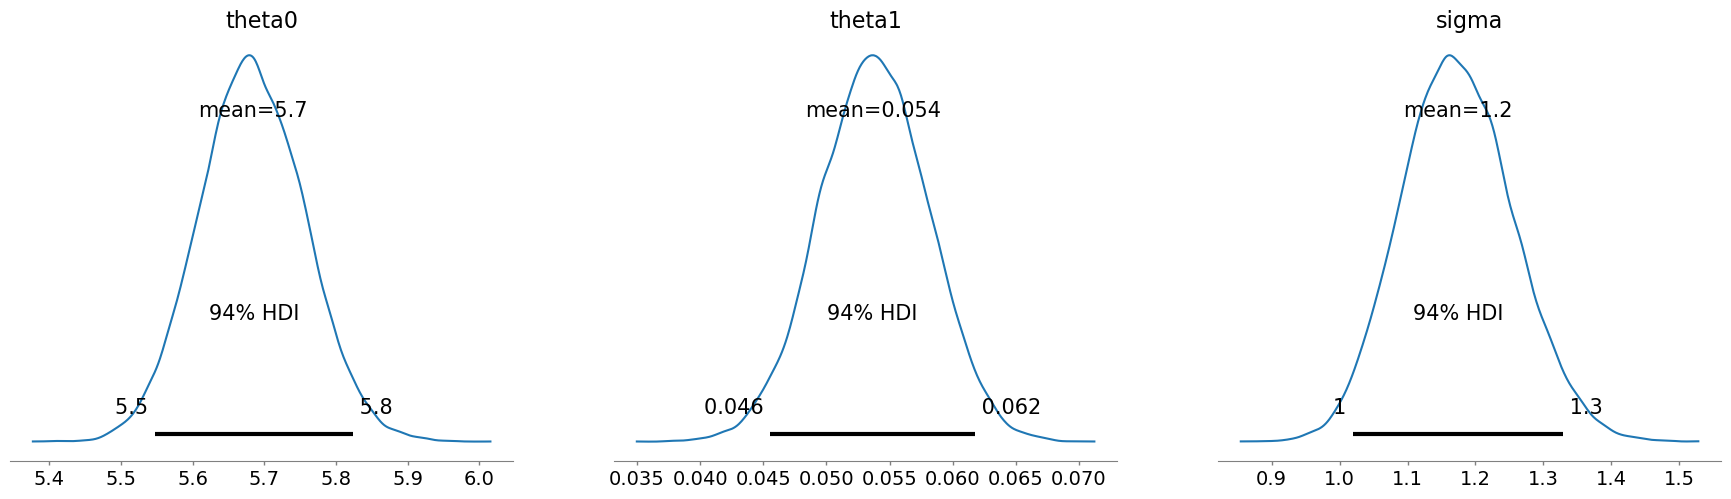

And use the exponential linear link to calculate the model-predicted mean values and store them a new variable in the `idata2.posterior` group.

Now lets plot the model, then sample from the posterior predictive distribution and plot those points. Evaluate this model as compared to our previouse linear model.

c:\Users\killi\anaconda3\envs\ml2025\Lib\site-packages\arviz\plots\lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


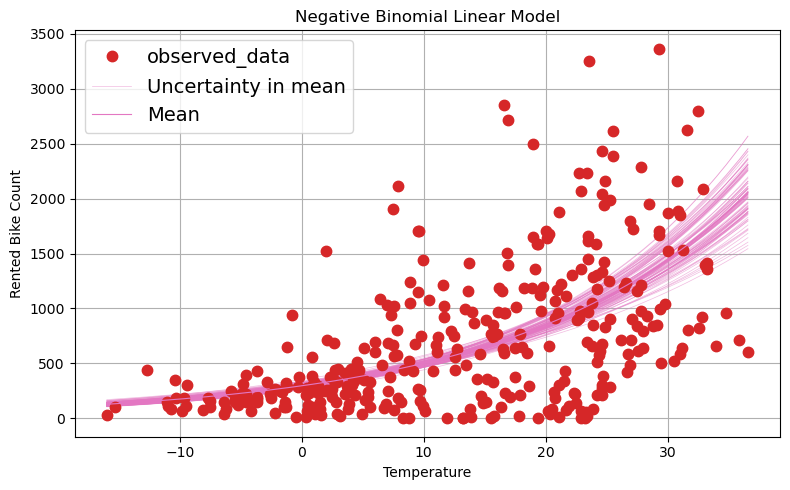

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
az.plot_lm(idata=idata2, y="y_pred", num_samples=100, x=x, axes=ax, y_model="y_model")
ax.set_title("Negative Binomial Linear Model")
ax.set_xlabel("Temperature")
ax.set_ylabel("Rented Bike Count")
fig.tight_layout()

Sampling: [y_pred]


Output()

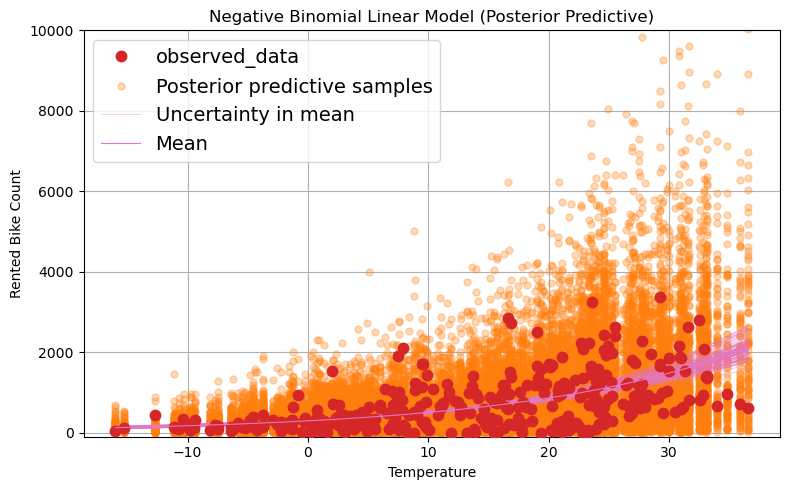

In [13]:
with negbin_model:
    pm.sample_posterior_predictive(trace=idata2, extend_inferencedata=True)

fig, ax = plt.subplots(figsize=(8, 5))
az.plot_lm(idata=idata2, y="y_pred", num_samples=100, x=x, axes=ax, y_model="y_model")
ax.set_ylim(-100, 10_000)
ax.set_title("Negative Binomial Linear Model (Posterior Predictive)")
ax.set_xlabel("Temperature")
ax.set_ylabel("Rented Bike Count")
fig.tight_layout()

## Heirarchical Modelling
Anpother next type of model we can make with Bayesian modelling is one which effectively captures data heirarchies or latent variables. As an example of this we will work though the hierarchical linear model from the lecture.

The first thing we do is to generate the data such that there are 8 groups with slighly varying intercepts and slopes, with all but one having 20 observations, and the final one having only one.

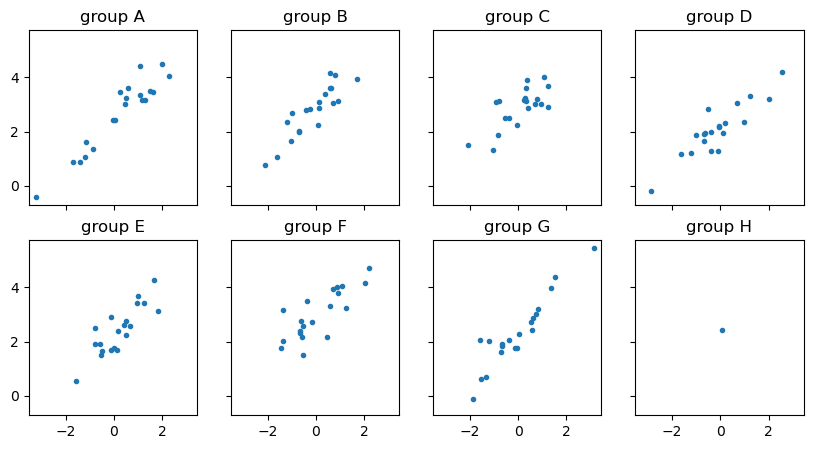

In [ ]:
N = 20
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
M = len(groups)
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(0, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_title(f"group {g}")

    j += N
    k += N

### Fully Pooled Model
One way we can think of modeling this data is to assume that the data from all groups are generated from the same model. This is called a fully pooled model. We estimate the same parameters for all groups, and we ignore the group structure in the data. This is equivalent to a linear regression model with a single intercept and slope.


In [ ]:
#fully pooled model
with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", 10)
    y_obs = pm.Normal("y_obs", mu=alpha + beta * x_m, sigma=sigma, observed=y_m)

    idata3 = pm.sample(draws=10_000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 68 seconds.


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

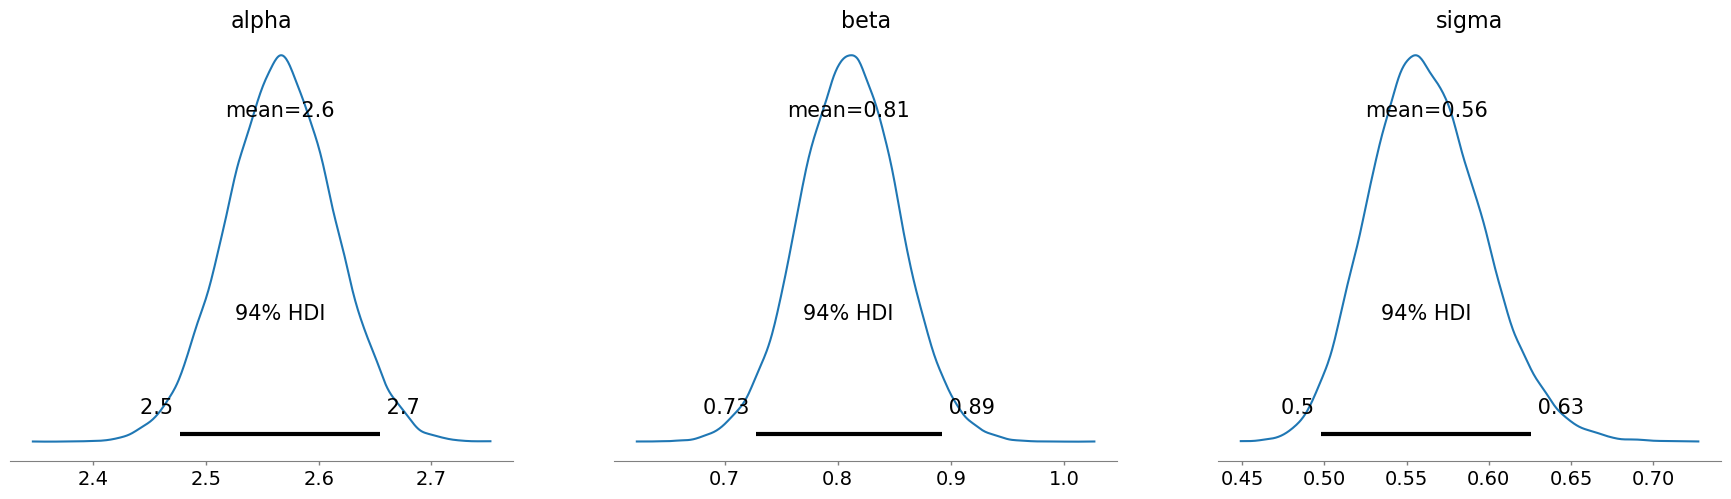

In [38]:
az.plot_posterior(idata3, var_names=["alpha", "beta", "sigma"])

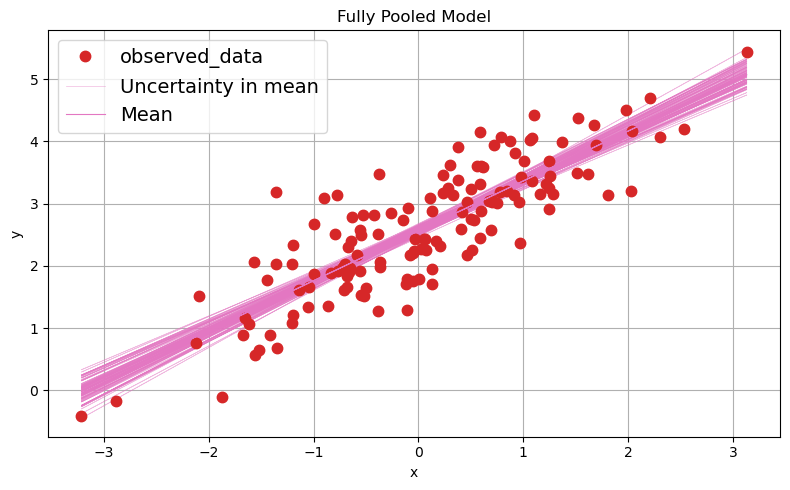

In [40]:
idata3.posterior["y_model"] = idata3.posterior["alpha"] + idata3.posterior["beta"] * xr.DataArray(x_m)
fig, ax = plt.subplots(figsize=(8, 5))
az.plot_lm(idata=idata3, y="y_obs", num_samples=100, x=x_m, axes=ax, y_model="y_model")
ax.set_title("Fully Pooled Model")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()

### Non-Pooled model
In this case we know that the groups are not related, so we should use models which allow for different parameters for each group. The assumption now is that each grou is entirely independent of the others.

In [ ]:
coords = {"group": groups}

with pm.Model(coords=coords) as unpooled_model:
    α = pm.Normal("α", mu=0, sigma=10, dims="group")
    β = pm.Normal("β", mu=0, sigma=10, dims="group")
    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)
    idata_up = pm.sample(random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

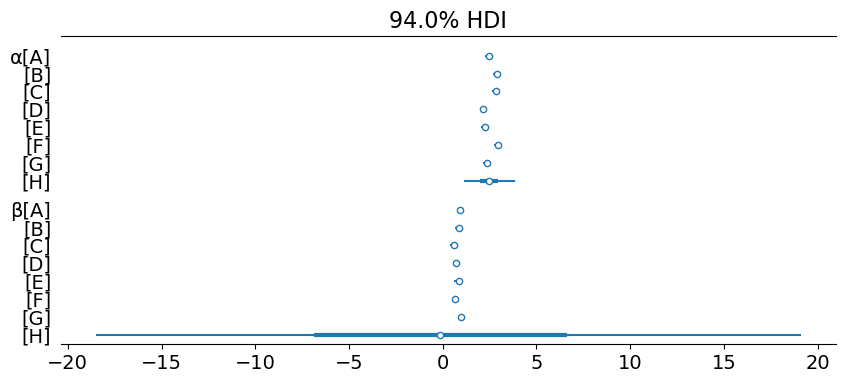

In [28]:
az.plot_forest(idata_up, var_names=["α", "β"], combined=True, figsize=(10, 4))

### Partially Pooled Model
Both of the above models are not ideal. The fully pooled model does not account for the group structure, while the unpooled model does not share information across groups. A partially pooled model can be used to share information across groups while still allowing for group-specific effects. This is done by placing hyper-priors on the group-level parameters. The hyper-priors are typically placed on the mean and standard deviation of the group-level parameters. This allows for a more flexible model that can adapt to the data while still sharing information across groups.

In [ ]:
with pm.Model(coords=coords) as hierarchical_centered:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="group")
    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_cen = pm.sample(random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 352 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


As we can see above, centered heriarchical models can be problematic when the data is sparse and run into issues with convergence. As such we can use a non-centered parameterization to help with this. To do this we model an overall mean and standard deviation for all groups and then model the group level parameters as a linear combination of this overall mean with an offset multiplied by the standard deviation. This gives us the same effect as before just under different parameterisation, which allows our sampler to explore the posterior better.

For a more in-depth treatment of this idea see this notebook:
https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/

In [ ]:
with pm.Model(coords=coords) as hierarchical_non_centered:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group")

    β_offset = pm.Normal("β_offset", mu=0, sigma=1, dims="group")
    β = pm.Deterministic("β", β_μ + β_offset * β_σ, dims="group")

    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_ncen = pm.sample(random_seed=123, target_accept=0.85)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β_offset, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

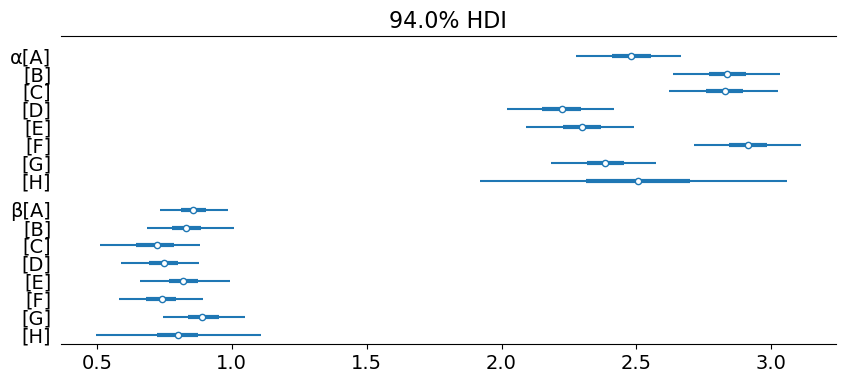

In [32]:
az.plot_forest(idata_ncen, var_names=["α", "β"], combined=True, figsize=(10, 4))

Now that we have those more stable estimates we can plot the group level regression with their uncertainty. Below I have given quick intros to two key concepts that are considered the main advanatges of partial-pooling, see if you can spot examples of their effects below.

**Shrinkage** refers to the way group-level estimates are pulled toward the overall population mean. This helps avoid overfitting, especially when group-level data is sparse or noisy.

**Borrowing strength** means that information is shared across groups through the hierarchical structure. Groups with limited data benefit from the data of others, improving the stability and accuracy of their estimates.

c:\Users\killi\anaconda3\envs\ml2025\Lib\site-packages\arviz\plots\hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\killi\anaconda3\envs\ml2025\Lib\site-packages\arviz\plots\hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\killi\anaconda3\envs\ml2025\Lib\site-packages\arviz\plots\hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\User

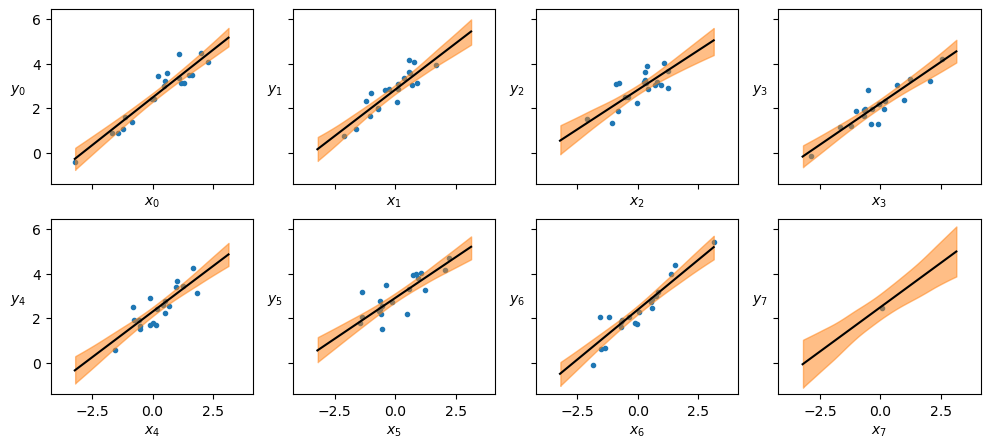

In [33]:
_, ax = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
posterior = az.extract(idata_ncen)

for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_xlabel("$x_{}$".format(i))
    ax[i].set_ylabel("$y_{}$".format(i), labelpad=10, rotation=0)
    alfas = posterior["α"].sel(group=g)
    betas = posterior["β"].sel(group=g)
    alfa_m = alfas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    ax[i].plot(x_range, alfa_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alfas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    plt.xlim(x_m.min() - 1, x_m.max() + 1)
    plt.ylim(y_m.min() - 1, y_m.max() + 1)
    j += N
    k += N

c:\Users\killi\anaconda3\envs\ml2025\Lib\site-packages\arviz\plots\hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\killi\anaconda3\envs\ml2025\Lib\site-packages\arviz\plots\hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\killi\anaconda3\envs\ml2025\Lib\site-packages\arviz\plots\hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\User

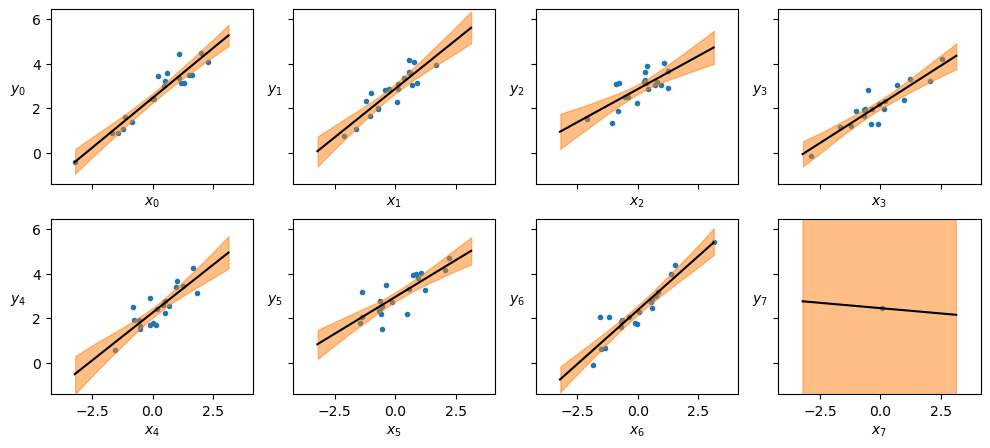

In [35]:
# same plot but also with the unpooled model
_, ax = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
posterior = az.extract(idata_up)

for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_xlabel("$x_{}$".format(i))
    ax[i].set_ylabel("$y_{}$".format(i), labelpad=10, rotation=0)
    alfas = posterior["α"].sel(group=g)
    betas = posterior["β"].sel(group=g)
    alfa_m = alfas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    ax[i].plot(x_range, alfa_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alfas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    plt.xlim(x_m.min() - 1, x_m.max() + 1)
    plt.ylim(y_m.min() - 1, y_m.max() + 1)
    j += N
    k += N
plt.show()

Open discussion: Can you think of some examples of nested data you know? What might the structurs for a heirarchical model look like for that data?

## Bonus: Time Series with Bayes
If you are done all the above or your project is focused on time-series modelling, here is a really interesting appraoch which essentially is a probabilistic version of Facebook's famous Prophet model. Check it out here: 
https://www.pymc.io/projects/examples/en/latest/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html